# Generate full emissions portfolio from projected Kyoto gas baskets
Updated to include announcements as of COP26, 5/11/21. Including an analysis of full impact of Net Zero commitments on emissions.
# Part 2: extend and infill data

In [1]:
import sys
stdout = sys.stdout

In [2]:
import country_converter
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pyam
import pymagicc
import re
import scmdata
from scipy.interpolate import interp1d, PchipInterpolator

<IPython.core.display.Javascript object>

In [3]:
from silicone.time_projectors import ExtendLatestTimeQuantile
import silicone.multiple_infillers as mi
import silicone.database_crunchers as dc
from silicone.utils import convert_units_to_MtCO2_equiv, _construct_consistent_values

In [4]:
infill_quantile = 0.5
version_no = f"v7_quant{infill_quantile}"

# Import the data

In [5]:
co2 = "Emissions|CO2"
co2ind = "Emissions|CO2|Energy and Industrial Processes"
co2afolu = "Emissions|CO2|AFOLU"
variable = "Emissions|Kyoto Gases (AR6-GWP100)"
kyotoar5 = 'Emissions|Kyoto Gases (AR5-GWP100)'
kyexaf = variable + "|Excluding CO2 AFOLU"
unit = "Mt CO2-equiv/yr"
co2unit = "Mt CO2/yr"
kyoto_gases = [co2ind, co2afolu, "Emissions|CH4", "Emissions|N2O", "Emissions|F-Gases"]

In [6]:
years = [2010, 2015] + list(range(2020, 2101, 10))
fgas = "Emissions|F-Gases"
fgases = ["Emissions|HFC", 'Emissions|PFC', 'Emissions|SF6']
pfc = "Emissions|PFC"
hfc = "Emissions|HFC"
pfcs = ['Emissions|PFC|C2F6', 'Emissions|PFC|CF4']
hfcs = [
    'Emissions|HFC|HFC125',
    'Emissions|HFC|HFC134a',
    'Emissions|HFC|HFC143a',
    'Emissions|HFC|HFC227ea',
    'Emissions|HFC|HFC23',
    'Emissions|HFC|HFC32',
    'Emissions|HFC|HFC43-10',
    'Emissions|HFC|HFC245fa'
]
sf6 = "Emissions|SF6"

In [7]:
filter_file = pd.read_excel("../input/model_classification.xlsx")
kygemname = "GEMINI_E3 from Kyoto"
our_map = {"GEMINI-E3 7.0": "RD_CGE", "GCAM-PR 5.3": "RD_PE", "MUSE": "RD_PE", kygemname:"RD_CGE"}
filter_file.head()

,Model,Model_Type
0,AIM/CGE 2.0,RD_CGE
1,AIM/CGE 2.1,RD_CGE
2,AIM/CGE 2.2,RD_CGE
3,AIM/Hub-Global 2.0,RD_CGE
4,C-ROADS-5.005,SD


In [8]:
out_folder = "../output/processed_files/"
harm_all = pyam.IamDataFrame(out_folder + f"harm_all_{version_no.split('_quant')[0]}.csv")
harmed_ar6  = pyam.IamDataFrame(out_folder + "ar6_cleaned_harmed.csv").filter(year=years)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\output\processed_files\harm_all_v7.csv
pyam.core - INFO: Reading file ..\output\processed_files\ar6_cleaned_harmed.csv


In [9]:
model_map = {x: [y for y in harmed_ar6.model if y in filter_file["Model"][
    filter_file["Model_Type"]==z].values ] for x, z in our_map.items()}
model_map["TIAM_Grantham"] = ["TIAM-UCL 4.1.1", "MESSAGE*"]

In [10]:
model_map

{'GEMINI-E3 7.0': ['AIM/CGE 2.0',
  'AIM/CGE 2.1',
  'AIM/CGE 2.2',
  'AIM/Hub-Global 2.0',
  'EPPA 6',
  'GEM-E3_V2021'],
 'GCAM-PR 5.3': ['GCAM 4.0',
  'GCAM 4.2',
  'GCAM 5.2',
  'GCAM 5.3',
  'GCAM-PR 5.3',
  'IMAGE 3.0',
  'IMAGE 3.0.1',
  'IMAGE 3.0.2',
  'IMAGE 3.2',
  'POLES ADVANCE',
  'POLES CD-LINKS',
  'POLES EMF30',
  'POLES EMF33',
  'POLES ENGAGE',
  'POLES GECO2019'],
 'MUSE': ['GCAM 4.0',
  'GCAM 4.2',
  'GCAM 5.2',
  'GCAM 5.3',
  'GCAM-PR 5.3',
  'IMAGE 3.0',
  'IMAGE 3.0.1',
  'IMAGE 3.0.2',
  'IMAGE 3.2',
  'POLES ADVANCE',
  'POLES CD-LINKS',
  'POLES EMF30',
  'POLES EMF33',
  'POLES ENGAGE',
  'POLES GECO2019'],
 'GEMINI_E3 from Kyoto': ['AIM/CGE 2.0',
  'AIM/CGE 2.1',
  'AIM/CGE 2.2',
  'AIM/Hub-Global 2.0',
  'EPPA 6',
  'GEM-E3_V2021'],
 'TIAM_Grantham': ['TIAM-UCL 4.1.1', 'MESSAGE*']}

In [11]:
# Check the AR6 db with filtering
scenario_string = "*SSP2*"
for key, modt in model_map.items():
    harmed_ar6_filt = harmed_ar6.filter(model=modt)
    ssp2harmedfilt = harmed_ar6_filt.filter(scenario=scenario_string).data.loc[:, ["model", "scenario"]].drop_duplicates()
    varcount = len(harmed_ar6_filt.filter(scenario=scenario_string).variable)
    print(
        f'{key} has len {len(harmed_ar6_filt.data.loc[:, ["model", "scenario"]].drop_duplicates())} and {len(ssp2harmedfilt)}, varcount {varcount}'
    )

GEMINI-E3 7.0 has len 211 and 39, varcount 23
GCAM-PR 5.3 has len 441 and 35, varcount 27
MUSE has len 441 and 35, varcount 27
GEMINI_E3 from Kyoto has len 211 and 39, varcount 23
TIAM_Grantham has len 301 and 33, varcount 25


In [12]:
# Rename units
harmed_ar6 = harmed_ar6.rename({"unit": {"kt HFC43-10/yr": "kt HFC4310mee/yr"}})

# Project CO2 energy and industrial total to 2100 directly and infill all values from this
One scenario is incomplete at present.

In [13]:
harm_all.filter(model="GEMINI*", scenario="Baseline*").timeseries().head()

2000  \
model         scenario            region variable                                      unit                            
GEMINI-E3 7.0 Baseline|Harmonized World  Emissions|CH4                                 Mt CH4/yr          310.188077   
                                         Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        25259.641383   
                                         Emissions|F-Gases                             Mt CO2-equiv/yr    388.111600   
                                         Emissions|N2O                                 kt N2O/yr         9610.000000   
                                         Emissions|PFC                                 Mt CO2-equiv/yr     96.741600   

                                                                                                                2005  \
model         scenario            region variable                                      unit                            
GEMINI-E3 7.0 Baseline|Harmonized World  Emissions|CH4                                 Mt CH4/yr          346.395724   
                                         Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        29658.164263   
                                         Emissions|F-Gases                             Mt CO2-equiv/yr    526.656700   
                                         Emissions|N2O                                 kt N2O/yr        10500.000000   
                                         Emissions|PFC                                 Mt CO2-equiv/yr     93.971700   

                                                                                                                2010  \
model         scenario            region variable                                      unit                            
GEMINI-E3 7.0 Baseline|Harmonized World  Emissions|CH4                                 Mt CH4/yr          370.896512   
                                         Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        32890.397797   
                                         Emissions|F-Gases                             Mt CO2-equiv/yr    842.367600   
                                         Emissions|N2O                                 kt N2O/yr        10500.000000   
                                         Emissions|PFC                                 Mt CO2-equiv/yr     81.657600   

                                                                                                                2015  \
model         scenario            region variable                                      unit                            
GEMINI-E3 7.0 Baseline|Harmonized World  Emissions|CH4                                 Mt CH4/yr          388.072795   
                                         Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        35635.286298   
                                         Emissions|F-Gases                             Mt CO2-equiv/yr   1218.585100   
                                         Emissions|N2O                                 kt N2O/yr        10900.000000   
                                         Emissions|PFC                                 Mt CO2-equiv/yr     89.495100   

                                                                                                                2020  \
model         scenario            region variable                                      unit                            
GEMINI-E3 7.0 Baseline|Harmonized World  Emissions|CH4                                 Mt CH4/yr          398.255828   
                                         Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        35822.815474   
                                         Emissions|F-Gases                             Mt CO2-equiv/yr   1483.348634   
                                         Emissions|N2O                                 kt N2O/yr        11355.198275   
                            

In [14]:
# Gemini from kyoto only has Kyoto total, so we first split it down
splitter = mi.SplitCollectionWithRemainderEmissions(harmed_ar6)
gem_ky_breakdown = splitter.infill_components(
    "Emissions|Kyoto Gases (AR5-GWP100)",
    components=[g for g in kyoto_gases if g != co2ind],
    remainder=co2ind,
    to_infill_df=harm_all.filter(model=kygemname, year=years)
)

In [15]:
gem_ky_breakdown = gem_ky_breakdown.filter(variable=co2ind, keep=False).append(
    gem_ky_breakdown.filter(variable=co2ind).rename({"unit": {"Mt CO2-equiv/yr": "Mt CO2/yr"}})
)

In [16]:
harm_all = harm_all.append(gem_ky_breakdown)

In [17]:
gem_ky_breakdown.filter(variable=co2ind).timeseries()

2010  \
model                scenario          region variable                                      unit                      
GEMINI_E3 from Kyoto CP_EI|Harmonized  World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  32890.397797   
                     LTS|Harmonized    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  32890.397797   
                     NDC_EI|Harmonized World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  32890.397797   

                                                                                                               2015  \
model                scenario          region variable                                      unit                      
GEMINI_E3 from Kyoto CP_EI|Harmonized  World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  35635.286298   
                     LTS|Harmonized    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  35635.286298   
                     NDC_EI|Harmonized World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  35635.286298   

                                                                                                               2020  \
model                scenario          region variable                                      unit                      
GEMINI_E3 from Kyoto CP_EI|Harmonized  World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  31008.626118   
                     LTS|Harmonized    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  31275.603391   
                     NDC_EI|Harmonized World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  31008.626118   

                                                                                                               2030  \
model                scenario          region variable                                      unit                      
GEMINI_E3 from Kyoto CP_EI|Harmonized  World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  34511.492470   
                     LTS|Harmonized    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  32711.339788   
                     NDC_EI|Harmonized World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  32711.338306   

                                                                                                               2040  \
model                scenario          region variable                                      unit                      
GEMINI_E3 from Kyoto CP_EI|Harmonized  World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  34220.570619   
                     LTS|Harmonized    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  24488.246572   
                     NDC_EI|Harmonized World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  31064.541767   

                                                                                                               2050  \
model                scenario          region variable                                      unit                      
GEMINI_E3 from Kyoto CP_EI|Harmonized  World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  32132.727407   
                     LTS|Harmonized    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  15642.344942   
                     NDC_EI|Harmonized World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  28361.388051   

                                                                                                               2060  \
model                scenario          region variable                                      unit                      
GEMINI_E3 from Kyoto CP_EI|Harmonized  World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  30376.776100   
                     LTS|Harmonized    World  Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   8893.335817   
                     NDC_EI|Harmonized World  Emissions|CO2

In [18]:
# GEMINI has no emissions for after2050, so we extend them via the latest time quantile
try: 
    del additionaltime
except:
    pass
extender = ExtendLatestTimeQuantile(harmed_ar6)
for species in harm_all.filter(model="GEMINI*", scenario="Baseline*").variable:
    ext = extender.derive_relationship(species)(
        harm_all.filter(model="GEMINI*", scenario="Baseline*"))
    try:
        additionaltime = additionaltime.append(ext)
    except:
        additionaltime = ext
additionaltime.timeseries()

silicone.time_projectors.extend_latest_time_quantile - WARNING: The input database may be inconsistent at later times
silicone.time_projectors.extend_latest_time_quantile - WARNING: The input database may be inconsistent at later times
silicone.time_projectors.extend_latest_time_quantile - WARNING: The input database may be inconsistent at later times
silicone.time_projectors.extend_latest_time_quantile - WARNING: The input database may be inconsistent at later times
silicone.time_projectors.extend_latest_time_quantile - WARNING: The input database may be inconsistent at later times
silicone.time_projectors.extend_latest_time_quantile - WARNING: The input database may be inconsistent at later times
silicone.time_projectors.extend_latest_time_quantile - WARNING: The input database may be inconsistent at later times


2060  \
model         scenario            region variable                                      unit                            
GEMINI-E3 7.0 Baseline|Harmonized World  Emissions|CH4                                 Mt CH4/yr          468.696577   
                                         Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        47536.951160   
                                         Emissions|F-Gases                             Mt CO2-equiv/yr   2859.809279   
                                         Emissions|N2O                                 kt N2O/yr        13050.836074   
                                         Emissions|PFC                                 Mt CO2-equiv/yr    102.297881   
                                         Emissions|PFC|CF4                             kt CF4/yr           11.976341   
                                         Emissions|SF6                                 kt SF6/yr           11.575448   

                                                                                                                2070  \
model         scenario            region variable                                      unit                            
GEMINI-E3 7.0 Baseline|Harmonized World  Emissions|CH4                                 Mt CH4/yr          466.363888   
                                         Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        47550.454867   
                                         Emissions|F-Gases                             Mt CO2-equiv/yr   2915.975000   
                                         Emissions|N2O                                 kt N2O/yr        12737.574200   
                                         Emissions|PFC                                 Mt CO2-equiv/yr     94.183791   
                                         Emissions|PFC|CF4                             kt CF4/yr           11.840900   
                                         Emissions|SF6                                 kt SF6/yr           11.019962   

                                                                                                                2080  \
model         scenario            region variable                                      unit                            
GEMINI-E3 7.0 Baseline|Harmonized World  Emissions|CH4                                 Mt CH4/yr          463.400117   
                                         Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        48149.452883   
                                         Emissions|F-Gases                             Mt CO2-equiv/yr   2811.743900   
                                         Emissions|N2O                                 kt N2O/yr        12611.080519   
                                         Emissions|PFC                                 Mt CO2-equiv/yr     89.003772   
                                         Emissions|PFC|CF4                             kt CF4/yr           11.592900   
                                         Emissions|SF6                                 kt SF6/yr           11.388026   

                                                                                                                2090  \
model         scenario            region variable                                      unit                            
GEMINI-E3 7.0 Baseline|Harmonized World  Emissions|CH4                                 Mt CH4/yr          454.709814   
                                         Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        47010.851493   
                                         Emissions|F-Gases                             Mt CO2-equiv/yr   3134.472100   
                                         Emissions|N2O                                 kt N2O/yr        12470.566642   
                                         Emissions|PFC                                 Mt CO2-equiv/yr     79.825200   
                             

<AxesSubplot:title={'center':'model: GEMINI_E3 from Kyoto - region: World - variable: Emissions|Kyoto Gases (AR5-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

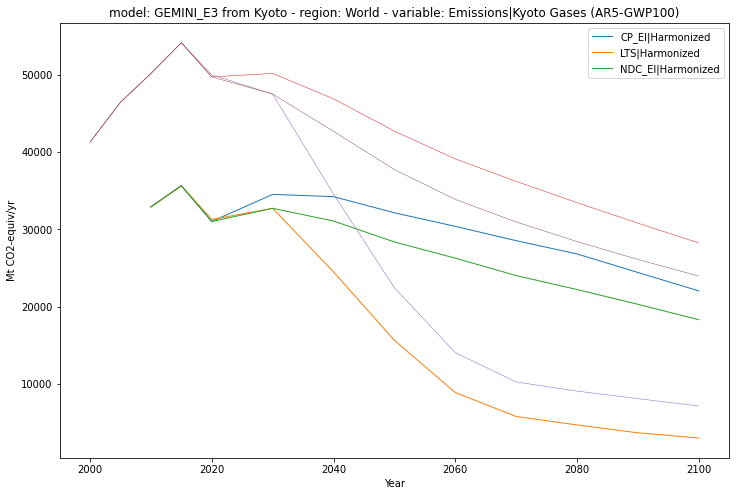

In [19]:
plt.figure(figsize=(12,8))
ax=plt.subplot()
gem_ky_breakdown.filter(variable=co2ind).plot(ax=ax, linewidth=1)
harm_all.filter(variable="*Kyoto*").plot(ax=ax, linewidth=0.5)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: GEMINI-E3 7.0 - scenario: Baseline|Harmonized - region: World - variable: Emissions|CO2|Energy and Industrial Processes'}, xlabel='Year', ylabel='Mt CO2/yr'>

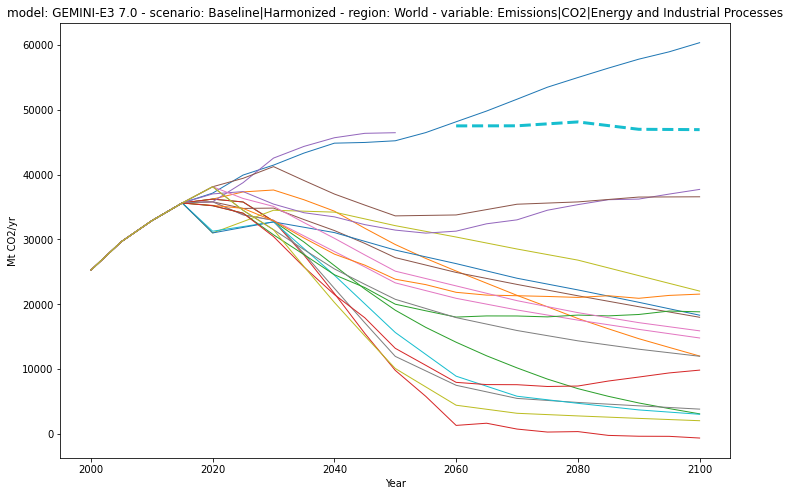

In [20]:
plt.figure(figsize=(12,8))
ax=plt.subplot()
harm_all.filter(variable=co2ind).plot(ax=ax, linewidth=1)
additionaltime.filter(variable=co2ind).plot(ax=ax, linestyle="--", linewidth=3)

In [21]:
harm_all = harm_all.append(additionaltime)

In [22]:
# Fill in the remaining 
required_vars = [
    "Emissions|BC",
    "Emissions|CH4",
    "Emissions|CO2|AFOLU",
    "Emissions|CO2|Energy and Industrial Processes",
    "Emissions|CO",
    "Emissions|N2O",
    "Emissions|NH3",
    "Emissions|NOx",
    "Emissions|OC",
    "Emissions|F-Gases",
    "Emissions|Sulfur",
    "Emissions|VOC",
    'Emissions|PFC|C6F14',  # These are just infilled with 0
]
try:
    del df
except:
    pass
for key, val in model_map.items():
    df1 = mi.infill_all_required_variables(
        harm_all.filter(model=key), harmed_ar6.filter(model=val, scenario=scenario_string), [co2ind], 
        required_vars, output_timesteps=years, quantile=infill_quantile
    )
    try:
        df = df.append(df1)
    except:
        df = df1

c:\users\rlamboll\constraincode\silicone\src\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:191: UserWarning: No data for ['Emissions|PFC|C6F14'], it will be infilled with 0s
  unavailable_variables
silicone.database_crunchers.constant_ratio - INFO: <class 'silicone.database_crunchers.constant_ratio.ConstantRatio'> won't use any information from the database
Filling required variables: 100%|██████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.39it/s]
silicone.database_crunchers.constant_ratio - INFO: <class 'silicone.database_crunchers.constant_ratio.ConstantRatio'> won't use any information from the database
Filling required variables: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Note that the lead variable ['Emissions|CO2|Energy and Industrial Processes'] goes negative.


Filling required variables: 100%|██████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.51it/s]
silicone.database_crunchers.constant_ratio - INFO: <class 'silicone.database_crunchers.constant_ratio.ConstantRatio'> won't use any information from the database
Filling required variables: 100%|██████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.62it/s]
silicone.database_crunchers.constant_ratio - INFO: <class 'silicone.database_crunchers.constant_ratio.ConstantRatio'> won't use any information from the database
Filling required variables: 100%|██████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.98it/s]
silicone.database_crunchers.constant_ratio - INFO: <class 'silicone.database_crunchers.constant_ratio.ConstantRatio'> won't use any information from the database
Filling required variables: 100%|██████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.00it/s]


pyam.plotting - INFO: >=13 labels, not applying legend


GEMINI-E3 7.0
39
['AIM/CGE 2.0']


pyam.plotting - INFO: >=13 labels, not applying legend


GCAM-PR 5.3
35
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']


pyam.plotting - INFO: >=13 labels, not applying legend


MUSE
35
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']
GEMINI_E3 from Kyoto
39
['AIM/CGE 2.0']


pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


TIAM_Grantham
33
['MESSAGE-GLOBIOM 1.0', 'MESSAGEix-GLOBIOM_GEI 1.0', 'TIAM-UCL 4.1.1']


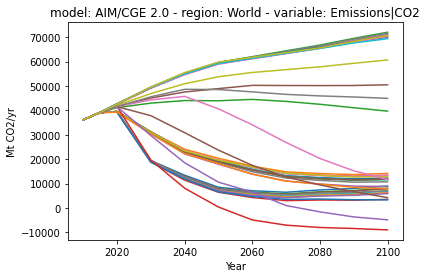

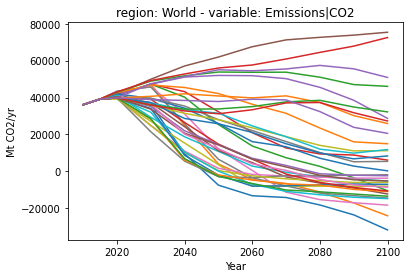

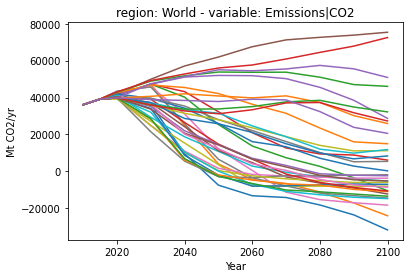

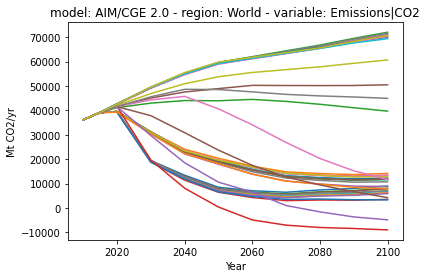

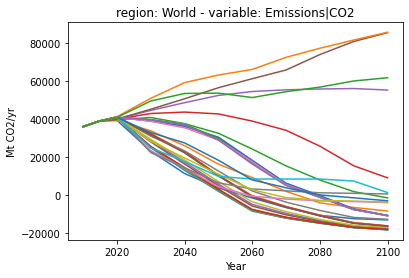

In [23]:
for key, val in model_map.items():
    print(key)
    co2modval = harmed_ar6.filter(model=val, scenario=scenario_string, variable="*CO2")
    print(len(co2modval.timeseries().reset_index()))
    print(co2modval.model)
    co2modval.plot()

pyam.plotting - INFO: >=13 labels, not applying legend


GEMINI-E3 7.0
39
['AIM/CGE 2.0']


pyam.plotting - INFO: >=13 labels, not applying legend


GCAM-PR 5.3
35
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']
MUSE
35
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']


pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


GEMINI_E3 from Kyoto
39
['AIM/CGE 2.0']


pyam.plotting - INFO: >=13 labels, not applying legend


TIAM_Grantham
29
['MESSAGE-GLOBIOM 1.0', 'MESSAGEix-GLOBIOM_GEI 1.0', 'TIAM-UCL 4.1.1']


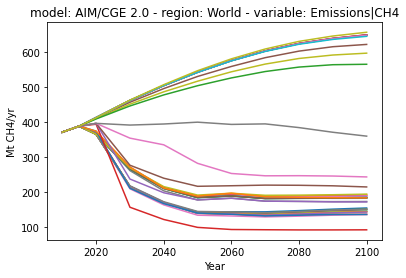

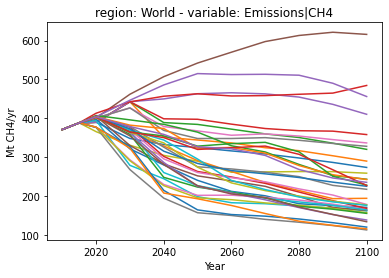

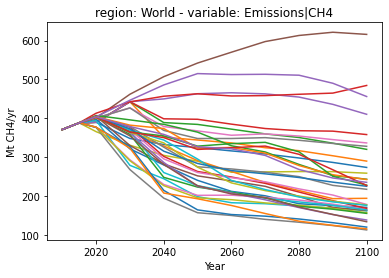

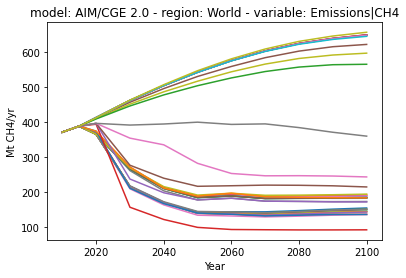

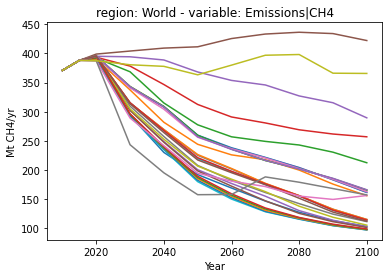

In [24]:
for key, val in model_map.items():
    print(key)
    co2modval = harmed_ar6.filter(model=val, scenario=scenario_string, variable="*CH4")
    print(len(co2modval.timeseries().reset_index()))
    print(co2modval.model)
    co2modval.plot()

GEMINI-E3 7.0
['AIM/CGE 2.0']
GCAM-PR 5.3
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']
MUSE
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']
GEMINI_E3 from Kyoto
['AIM/CGE 2.0']
TIAM_Grantham
['MESSAGE-GLOBIOM 1.0', 'MESSAGEix-GLOBIOM_GEI 1.0', 'TIAM-UCL 4.1.1']


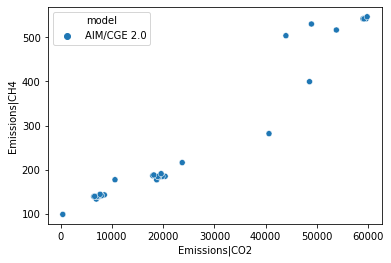

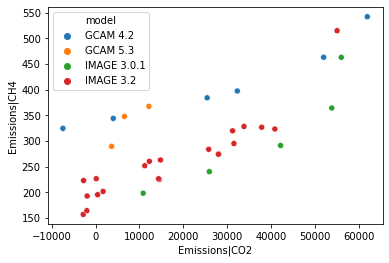

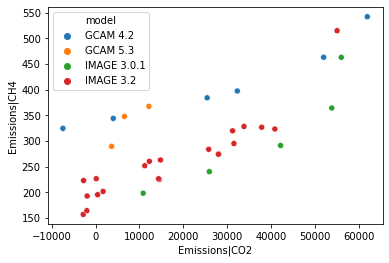

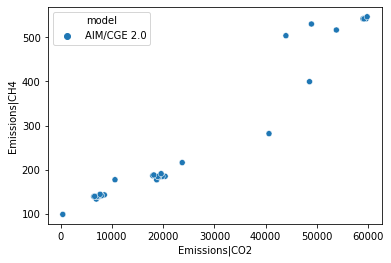

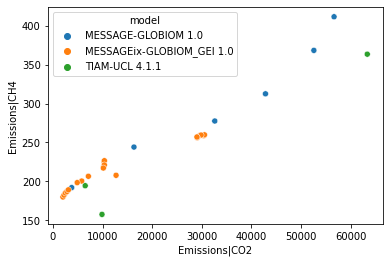

In [25]:
import seaborn as sns
for key, val in model_map.items():
    plt.figure()
    print(key)
    co2modval = harmed_ar6.filter(model=val, scenario=scenario_string, variable=["*CH4", "*CO2"], year=2050)
    print(co2modval.model)
    toplot = co2modval.data.pivot(values="value", columns=["variable"], index=["model", "scenario"]).reset_index("model")
    sns.scatterplot(data=toplot, x="Emissions|CO2", y="Emissions|CH4", hue="model")

GEMINI-E3 7.0
['AIM/CGE 2.0']
GCAM-PR 5.3
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']
MUSE
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']
GEMINI_E3 from Kyoto
['AIM/CGE 2.0']
TIAM_Grantham
['MESSAGE-GLOBIOM 1.0', 'MESSAGEix-GLOBIOM_GEI 1.0', 'TIAM-UCL 4.1.1']


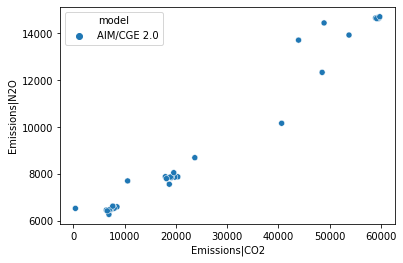

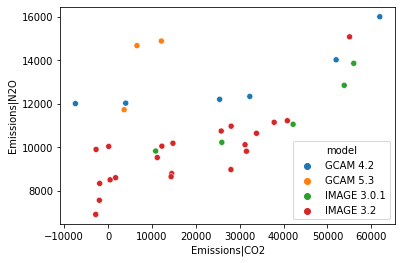

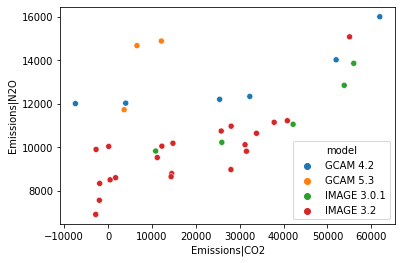

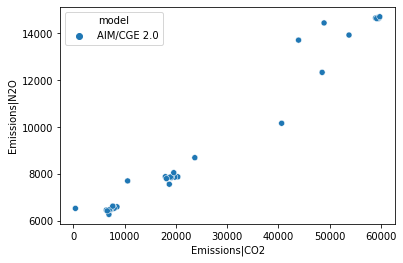

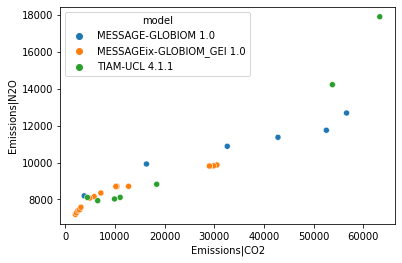

In [26]:
import seaborn as sns
for key, val in model_map.items():
    plt.figure()
    print(key)
    co2modval = harmed_ar6.filter(model=val, scenario=scenario_string, variable=["*N2O", "*CO2"], year=2050)
    print(co2modval.model)
    toplot = co2modval.data.pivot(values="value", columns=["variable"], index=["model", "scenario"]).reset_index("model")
    sns.scatterplot(data=toplot, x="Emissions|CO2", y="Emissions|N2O", hue="model")

GEMINI-E3 7.0
['AIM/CGE 2.0']
GCAM-PR 5.3
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']
MUSE
['GCAM 4.2', 'GCAM 5.3', 'IMAGE 3.0.1', 'IMAGE 3.2']
GEMINI_E3 from Kyoto
['AIM/CGE 2.0']
TIAM_Grantham
['MESSAGE-GLOBIOM 1.0', 'MESSAGEix-GLOBIOM_GEI 1.0', 'TIAM-UCL 4.1.1']


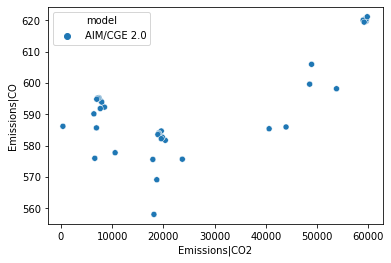

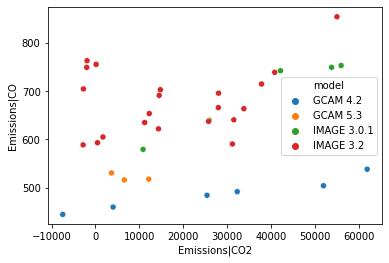

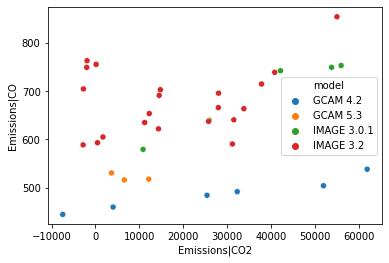

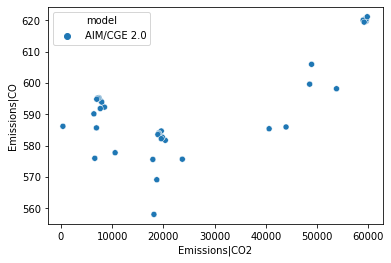

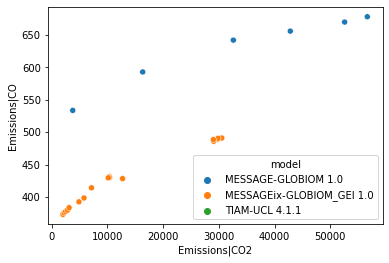

In [27]:
import seaborn as sns
for key, val in model_map.items():
    plt.figure()
    print(key)
    co2modval = harmed_ar6.filter(model=val, scenario=scenario_string, variable=["*CO", "*CO2"], year=2050)
    print(co2modval.model)
    toplot = co2modval.data.pivot(values="value", columns=["variable"], index=["model", "scenario"]).reset_index("model")
    sns.scatterplot(data=toplot, x="Emissions|CO2", y="Emissions|CO", hue="model")

In [28]:
harm_all.filter(model=key).variable

['Emissions|CO2|Energy and Industrial Processes']

In [29]:
not_hfcs = [x for x in df.model if ((x not in df.filter(variable=hfc).model) and (x in df.filter(variable=sf6).model) and 
                                    (x in df.filter(variable=pfc).model))]
hfc_add = mi.infill_composite_values(convert_units_to_MtCO2_equiv(df.filter(model=not_hfcs, variable=[fgas] + fgases)), 
                                     {hfc: {fgas: 1, sf6:-1, pfc: -1}})
df = df.append(hfc_add)
hfc_add

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : GEMINI-E3 7.0 (1)
 * scenario : Baseline|Harmonized, CP_EI|Harmonized, ... NDC_LTS|Harmonized (4)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|HFC (1)
   unit     : Mt CO2-equiv/yr (1)
   year     : 2010, 2015, 2020, 2030, 2040, 2050, 2060, 2070, ... 2100 (11)
Meta indicators:
   exclude (bool) False (1)

In [30]:
other_subgas = [x for x in df.model if ((x not in df.filter(variable=pfc).model) 
     and (x not in df.filter(variable=sf6).model) and (x in df.filter(variable=hfc).model))]

sf6pluspfcs = mi.infill_composite_values(convert_units_to_MtCO2_equiv(df.filter(model=other_subgas, variable=[fgas] + fgases)), 
                                     {"sf6pluspfcs": {fgas: 1, hfc: -1}})
sf6pluspfcs_sep = mi.DecomposeCollectionTimeDepRatio(harmed_ar6).infill_components(
    "sf6pluspfcs", [pfc, sf6], sf6pluspfcs)
sf6pluspfcs_sep.timeseries()
df = df.append(sf6pluspfcs_sep)
sf6pluspfcs_sep

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : GCAM-PR 5.3 (1)
 * scenario : Baseline|Harmonized, CP_EI|Harmonized, ... NDC_LTS|Harmonized (4)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|PFC, Emissions|SF6 (2)
   unit     : Mt CO2-equiv/yr, kt SF6/yr (2)
   year     : 2010, 2015, 2020, 2030, 2040, 2050, 2060, 2070, ... 2100 (11)
Meta indicators:
   exclude (bool) False (1)

<AxesSubplot:title={'center':'model: GCAM-PR 5.3 - region: World - variable: Emissions|SF6'}, xlabel='Year', ylabel='kt SF6/yr'>

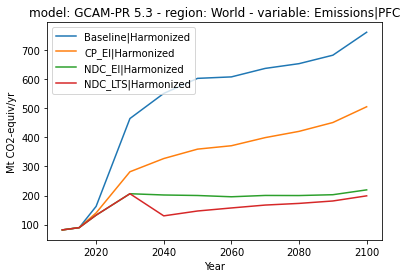

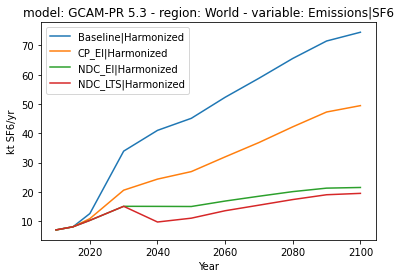

In [31]:
sf6pluspfcs_sep.filter(variable=pfc).plot()
sf6pluspfcs_sep.filter(variable=sf6).plot()

In [32]:
decomposer = mi.DecomposeCollectionTimeDepRatio(harmed_ar6)
other_fgases = decomposer.infill_components(
    fgas, fgases, df.filter(model=other_subgas + not_hfcs, keep=False))

In [33]:
harmed_ar6.unit

['Mt BC/yr',
 'Mt CH4/yr',
 'Mt CO/yr',
 'Mt CO2/yr',
 'Mt CO2-equiv/yr',
 'kt HFC125/yr',
 'kt HFC134a/yr',
 'kt HFC143a/yr',
 'kt HFC227ea/yr',
 'kt HFC23/yr',
 'kt HFC32/yr',
 'kt HFC4310mee/yr',
 'kt N2O/yr',
 'Mt NH3/yr',
 'Mt NO2/yr',
 'Mt OC/yr',
 'kt SF6/yr',
 'Mt SO2/yr',
 'Mt VOC/yr',
 'kt HFC245fa/yr',
 'kt C2F6/yr',
 'kt CF4/yr']

In [34]:
df = df.append(other_fgases)

In [35]:
individual_pfcs = decomposer.infill_components(pfc, pfcs, df.filter(variable=pfcs, keep=False))

In [36]:
individual_hfcs = decomposer.infill_components(hfc, hfcs, df)

In [37]:
all_values = pyam.concat([df.filter(variable=pfcs, keep=False), individual_pfcs, individual_hfcs])

In [38]:
all_values = all_values.filter(variable=co2, keep=False).append(_construct_consistent_values(
    co2, [co2afolu, co2ind], all_values.filter(variable=co2, keep=False)))

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.plotting - INFO: >=13 labels, not applying legend


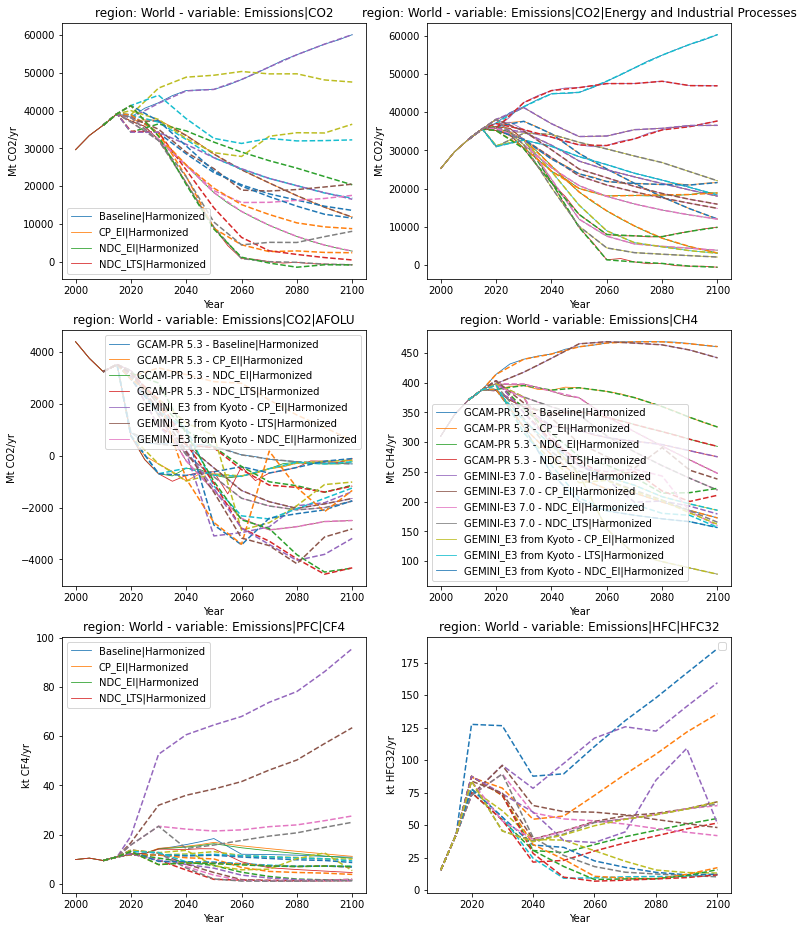

In [39]:
plt.figure(figsize=(12, 16))
for i, var in enumerate(["*CO2", co2ind, co2afolu, "*CH4", "*PFC|CF4", "*HFC|HFC32"]):
    ax = plt.subplot(3, 2, 1+i)
    harm_all.filter(variable=var).plot(ax=ax, linewidth=0.8)
    all_values.filter(variable=var).plot(ax=ax, linestyle="--")

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MUSE - region: World - variable: Emissions|CO2|AFOLU'}, xlabel='Year', ylabel='Mt CO2/yr'>

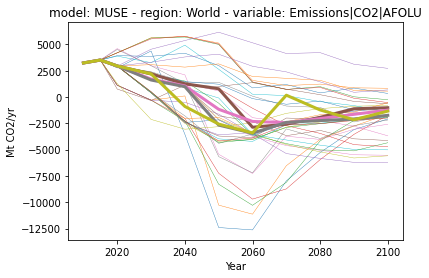

In [40]:
ax = plt.subplot()
harmed_ar6.filter(model=model_map["MUSE"], scenario=scenario_string, variable=co2afolu).plot(linewidth=0.4, ax=ax)
all_values.filter(variable="*AFOLU*", model="MUSE*").plot(ax=ax, linewidth=3)

In [41]:
assert all_values.filter(variable="*HFC*").timeseries().isna().sum().sum() == 0

In [42]:
assert all_values.filter(variable="*PFC*").timeseries().isna().sum().sum() == 0

In [43]:
assert all_values.filter(variable=fgas).timeseries().isna().sum().sum() == 0

In [44]:
all_extensions = all_values

In [45]:
# Synthesize the Kyoto total (usually only required if variable != kyoto total)
kyoto_emissions = [
    'Emissions|CO2|Energy and Industrial Processes',
    'Emissions|CO2|AFOLU',
    'Emissions|CH4',
    'Emissions|N2O',
    'Emissions|SF6',
    'Emissions|PFC|*',
    'Emissions|HFC'
]
all_extensions_kyoto = _construct_consistent_values(
    variable, kyoto_emissions, convert_units_to_MtCO2_equiv(
        all_extensions.filter(variable=kyoto_emissions), metric_name="AR6GWP100"
    )
)

In [46]:
tmp = all_extensions_kyoto.filter(year=2015).data
assert np.allclose(tmp.value.unique(), tmp.value[0], rtol=0.001)

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

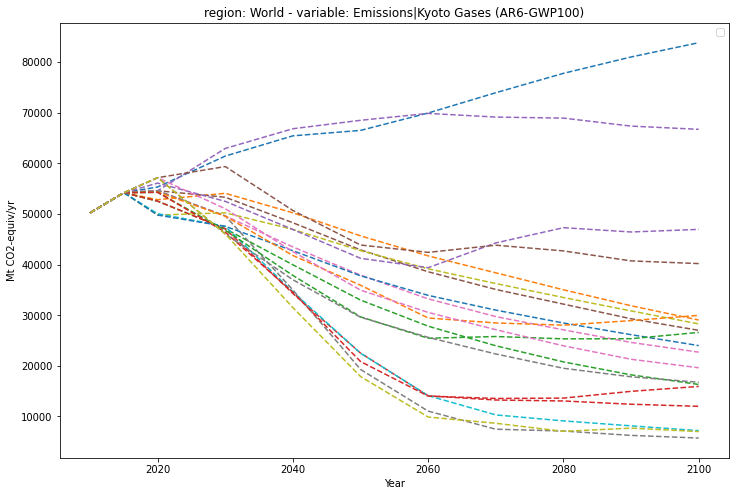

In [47]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
all_extensions.filter(variable=variable).plot(ax=ax, linewidth = 0.5)
plt.gca().set_prop_cycle(None)
all_extensions_kyoto.plot(linestyle="--", ax=ax)

In [48]:
all_extensions = all_extensions.filter(variable=variable, keep=False).append(all_extensions_kyoto)

In [49]:
all_extensions.filter(model=kygemname, variable="Emissions|Kyoto Gases (AR5-GWP100)", 
                          year=[y for y in all_extensions.year if y>2050]).scenario

['CP_EI|Harmonized', 'LTS|Harmonized', 'NDC_EI|Harmonized']

In [50]:
# Add a scenario based on GEMINI-E3 input until 2050, extended with constant quantile extension 
# and the remainder made up to the CO2ind total
extendedyear = [y for y in all_extensions.year if y>2050]
gemini_mixed = all_extensions.filter(model="GEMINI-E3 7.0", year=[y for y in all_extensions.year if y<=2050]).append(
    all_extensions.filter(model=kygemname, variable="Emissions|Kyoto Gases (AR5-GWP100)", 
                          year=extendedyear)
).filter(scenario="Base*", keep=False)
gemini_mixed = gemini_mixed.data
gemini_mixed["model"] = "GEMINI-E3 7.0-extended"
gemini_mixed.loc[gemini_mixed["scenario"]=="LTS|Harmonized", "scenario"] = "NDC_LTS|Harmonized"
gemini_mixed = pyam.IamDataFrame(gemini_mixed)

In [51]:
try: 
    del additionaltime
except:
    pass
extender = ExtendLatestTimeQuantile(
    harmed_ar6.filter(scenario=scenario_string, model=model_map["GEMINI-E3 7.0"], exclude=False, year=years))
emptyv = ["Emissions|PFC|C6F14", "Emissions|HFC|HFC245fa", "Emissions|PFC|C2F6", co2ind]
extender_vars = [v for v in required_vars if v not in emptyv]
for species in extender_vars:
    ext = extender.derive_relationship(species)(
        gemini_mixed)
    try:
        additionaltime = additionaltime.append(ext)
    except:
        additionaltime = ext

In [52]:
gemini_mixedfgases = decomposer.infill_components(fgas, fgases, additionaltime)
individual_pfcs = decomposer.infill_components(pfc, pfcs, gemini_mixedfgases)
individual_hfcs = decomposer.infill_components(hfc, hfcs, gemini_mixedfgases)

In [53]:
additionaltime.timeseries()

2060  \
model                  scenario           region variable            unit                            
GEMINI-E3 7.0-extended CP_EI|Harmonized   World  Emissions|BC        Mt BC/yr             3.476970   
                                                 Emissions|CH4       Mt CH4/yr          363.345486   
                                                 Emissions|CO        Mt CO/yr           549.126045   
                                                 Emissions|CO2|AFOLU Mt CO2/yr         -507.111967   
                                                 Emissions|F-Gases   Mt CO2-equiv/yr   1733.554595   
                                                 Emissions|N2O       kt N2O/yr        11882.919990   
                                                 Emissions|NH3       Mt NH3/yr           57.864829   
                                                 Emissions|NOx       Mt NO2/yr           44.071237   
                                                 Emissions|OC        Mt OC/yr            21.769120   
                                                 Emissions|Sulfur    Mt SO2/yr           12.426621   
                                                 Emissions|VOC       Mt VOC/yr          115.664245   
                       NDC_EI|Harmonized  World  Emissions|BC        Mt BC/yr             3.473290   
                                                 Emissions|CH4       Mt CH4/yr          329.259235   
                                                 Emissions|CO        Mt CO/yr           548.854955   
                                                 Emissions|CO2|AFOLU Mt CO2/yr         -523.661016   
                                                 Emissions|F-Gases   Mt CO2-equiv/yr   1545.691718   
                                                 Emissions|N2O       kt N2O/yr        11329.811142   
                                                 Emissions|NH3       Mt NH3/yr           57.862783   
                                                 Emissions|NOx       Mt NO2/yr           43.910018   
                                                 Emissions|OC        Mt OC/yr            21.742701   
                                                 Emissions|Sulfur    Mt SO2/yr           12.395569   
                                                 Emissions|VOC       Mt VOC/yr          115.625299   
                       NDC_LTS|Harmonized World  Emissions|BC        Mt BC/yr             3.443733   
                                                 Emissions|CH4       Mt CH4/yr          233.512758   
                                                 Emissions|CO        Mt CO/yr           558.710516   
                                                 Emissions|CO2|AFOLU Mt CO2/yr        -2889.141255   
                                                 Emissions|F-Gases   Mt CO2-equiv/yr    586.245324   
                                                 Emissions|N2O       kt N2O/yr         9668.400240   
                                                 Emissions|NH3       Mt NH3/yr           53.966131   
                                                 Emissions|NOx       Mt NO2/yr           35.884617   
                                                 Emissions|OC        Mt OC/yr            23.317380   
                                                 Emissions|Sulfur    Mt SO2/yr            9.553790   
                                                 Emissions|VOC       Mt VOC/yr          115.435696   

                                                                                              2070  \
model                  scenario           region variable            unit                            
GEMINI-E3 7.0-extended CP_EI|Harmonized   World  Emissions|BC        Mt BC/yr             3.288577   
                                                 Emissions|CH4       Mt CH4/yr          363.093894   
                                                 Emissions|CO        Mt CO/yr           519.076436   
             

In [54]:
geminic6f14 = dc.ConstantRatio().derive_relationship(
    "Emissions|PFC|C6F14", [fgas], 0, 'kt C6F14/yr')(additionaltime)

In [55]:
gemini_mixed = pyam.concat([gemini_mixed, additionaltime, gemini_mixedfgases, individual_pfcs, individual_hfcs, geminic6f14])

In [56]:
geminicomp = mi.infill_composite_values(
    convert_units_to_MtCO2_equiv(gemini_mixed.filter(variable=kyoto_gases + [kyotoar5], year=extendedyear), 
                                 metric_name="AR6GWP100"), 
    {co2ind: {kyotoar5: 1,  fgas: -1, "Emissions|N2O": -1, "Emissions|CH4": -1, co2afolu: -1},
    co2: {co2ind: 1, co2afolu: 1}}
)

In [57]:
geminicomp = geminicomp.rename({"unit": {unit: "Mt CO2/yr"}})

In [58]:
geminicomp.timeseries()

2060  \
model                  scenario           region variable                                      unit                      
GEMINI-E3 7.0-extended CP_EI|Harmonized   World  Emissions|CO2                                 Mt CO2/yr  23986.551049   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  24493.663016   
                       NDC_EI|Harmonized  World  Emissions|CO2                                 Mt CO2/yr  20035.431464   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  20559.092479   
                       NDC_LTS|Harmonized World  Emissions|CO2                                 Mt CO2/yr   4321.439376   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   7210.580631   

                                                                                                                  2070  \
model                  scenario           region variable                                      unit                      
GEMINI-E3 7.0-extended CP_EI|Harmonized   World  Emissions|CO2                                 Mt CO2/yr  20886.879361   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  21996.107221   
                       NDC_EI|Harmonized  World  Emissions|CO2                                 Mt CO2/yr  16992.286282   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  18118.136043   
                       NDC_LTS|Harmonized World  Emissions|CO2                                 Mt CO2/yr    358.403091   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   3094.816589   

                                                                                                                  2080  \
model                  scenario           region variable                                      unit                      
GEMINI-E3 7.0-extended CP_EI|Harmonized   World  Emissions|CO2                                 Mt CO2/yr  18873.932133   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  20026.151222   
                       NDC_EI|Harmonized  World  Emissions|CO2                                 Mt CO2/yr  15056.669733   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  16286.965364   
                       NDC_LTS|Harmonized World  Emissions|CO2                                 Mt CO2/yr   -664.188759   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr   1274.149594   

                                                                                                                  2090  \
model                  scenario           region variable                                      unit                      
GEMINI-E3 7.0-extended CP_EI|Harmonized   World  Emissions|CO2                                 Mt CO2/yr  16776.962535   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  18153.876399   
                       NDC_EI|Harmonized  World  Emissions|CO2                                 Mt CO2/yr  13195.007530   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  14591.699908   
                       NDC_LTS|Harmonized World  Emissions|CO2                                 Mt CO2/yr  -1466.245444   
                                                 Emissions|CO2|Energy and Industrial Processes Mt CO2/yr    360.705526   

                                                                                                                  2100  
model                  scenario           region variable                            

In [59]:
gemini_mixed = gemini_mixed.append(geminicomp)

pyam.core - WARNING: Filtered IamDataFrame is empty!


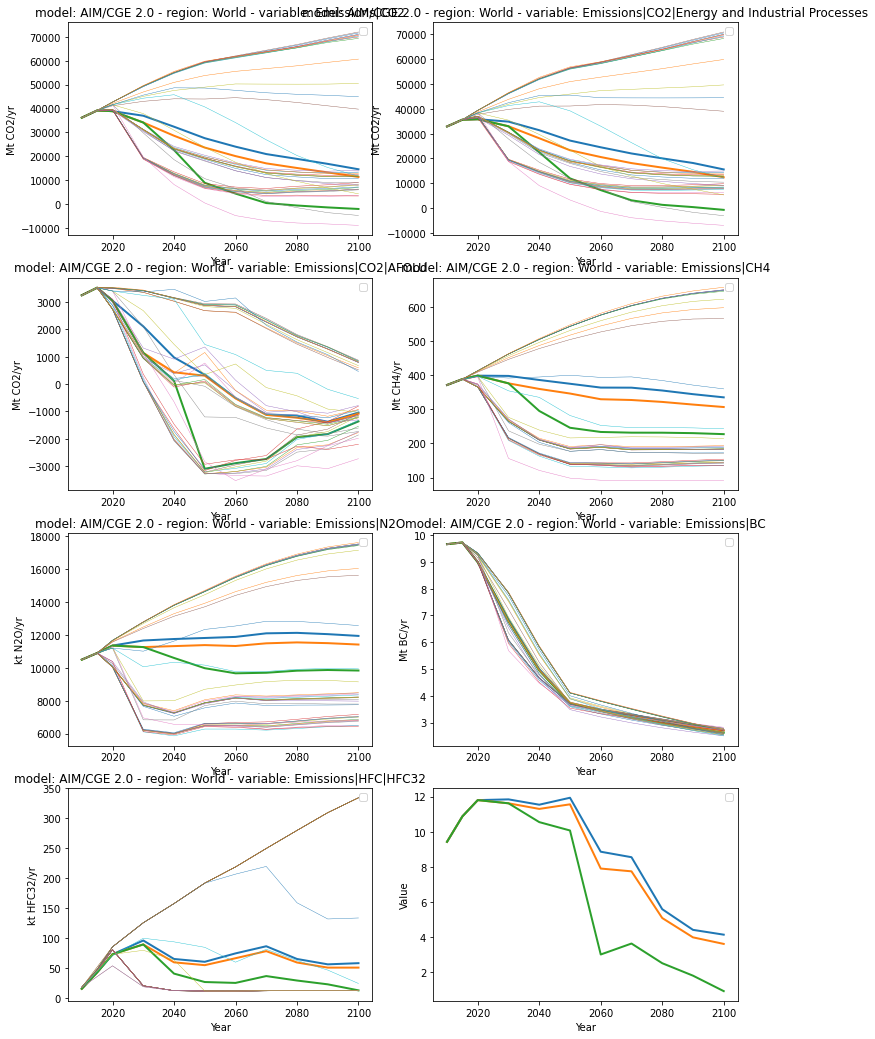

In [60]:
plt.figure(figsize=(12, 18))
for i, var in enumerate([co2, co2ind, co2afolu, "*CH4", "*N2O", "*BC", "*HFC|HFC32", "*CF4"]):
    ax = plt.subplot(4, 2, 1+i)
    gemini_mixed.filter(variable=var).plot(ax=ax, linewidth=2, label="_")
    harmed_ar6.filter(scenario=scenario_string, model=model_map["GEMINI-E3 7.0"], variable=var, exclude=False).plot(
        ax=ax, linewidth=0.4, label="_")

In [61]:
# We no longer want the other gemini versions, except for the baseline, which we should rename
gemini_baseline = all_extensions.filter(model="GEMINI*", scenario="Baseline*")
gemini_baseline = gemini_baseline.rename({"model":{'GEMINI-E3 7.0':gemini_mixed.model[0]}})
gemini_baseline

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : GEMINI-E3 7.0-extended (1)
 * scenario : Baseline|Harmonized (1)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|BC, Emissions|CH4, Emissions|CO, ... Emissions|VOC (28)
   unit     : Mt BC/yr, Mt CH4/yr, Mt CO/yr, Mt CO2-equiv/yr, ... kt SF6/yr (22)
   year     : 2010, 2015, 2020, 2030, 2040, 2050, 2060, 2070, ... 2100 (11)
Meta indicators:
   exclude (bool) False (1)
   already_filled (bool) False (1)

In [62]:
all_extensions = all_extensions.filter(model="GEMINI*", keep=False).append(gemini_mixed).append(gemini_baseline)

# Plot and investigate

In [63]:
assert all_extensions.check_aggregate(co2) == None

In [64]:
assert all_extensions.check_aggregate_region(co2) == None

pyam.aggregation - INFO: Cannot aggregate variable 'Emissions|CO2' to 'World' because it does not exist in any subregion!


pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

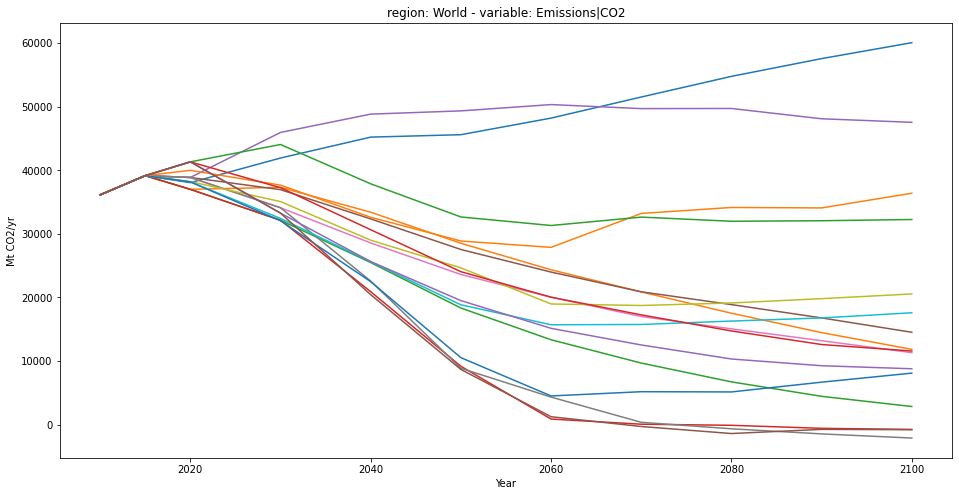

In [65]:
plt.figure(figsize=(16,8))
ax=plt.subplot(111)
all_extensions.filter(variable=co2, region="World").plot(ax=ax)

pyam.plotting - INFO: >=13 labels, not applying legend


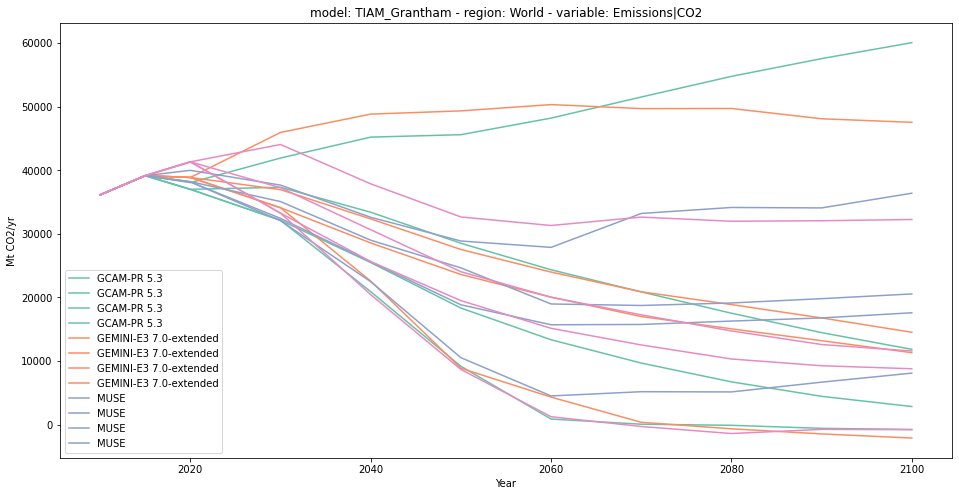

In [66]:
import seaborn as sns
rgb_values = sns.color_palette("Set2", len(all_extensions.model))
# Map continents to the colors
color_map = dict(zip(all_extensions.model, rgb_values))
plt.figure(figsize=(16,8))
ax=plt.subplot(111)
legstring = []
for model in all_extensions.model:
    all_extensions.filter(variable=co2, region="World", model=model).plot(ax=ax, color=color_map[model], label=model)


pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|SF6'}, xlabel='Year', ylabel='kt SF6/yr'>

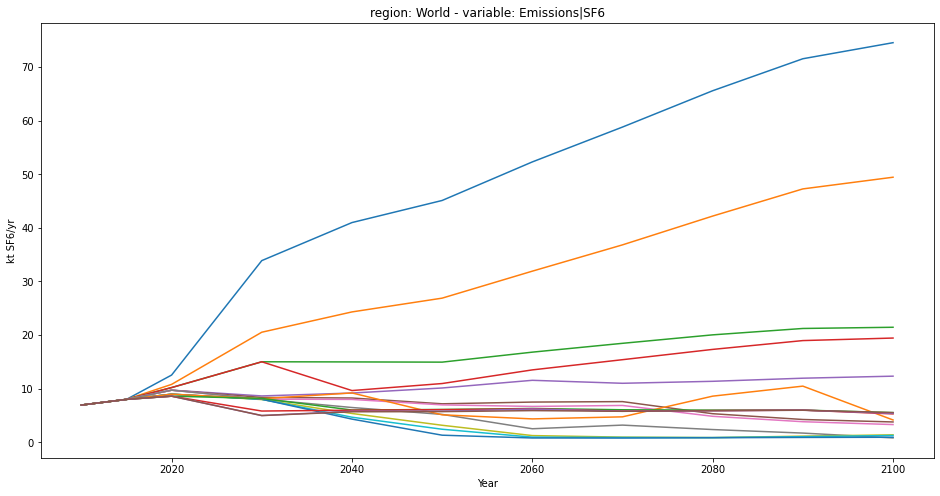

In [67]:
plt.figure(figsize=(16,8))
ax=plt.subplot(111)
all_extensions.filter(variable="Emissions|SF6").plot(ax=ax)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|F-Gases'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

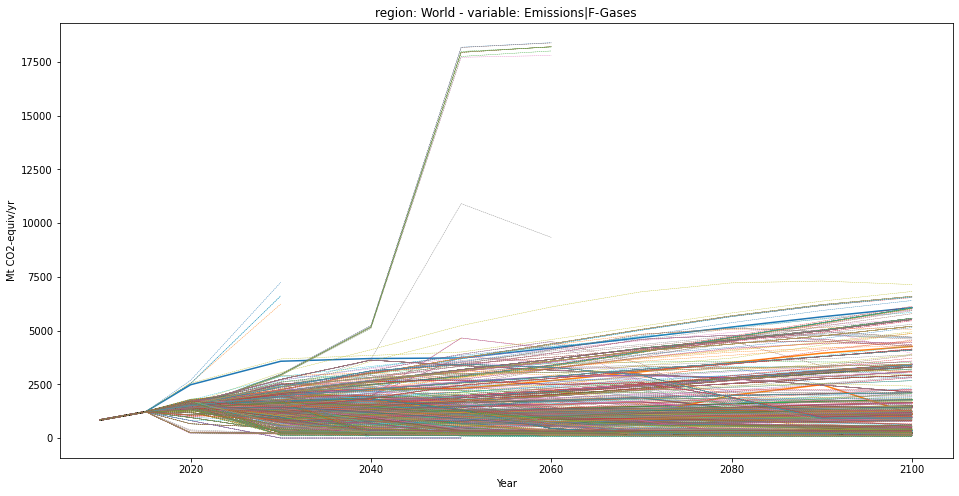

In [68]:
plt.figure(figsize=(16,8))
ax=plt.subplot(111)
all_extensions.filter(variable="Emissions|F-Gases").plot(ax=ax)
harmed_ar6.filter(variable="Emissions|F-Gases").plot(ax=ax, linestyle="--", linewidth=0.4)

In [69]:
assert len(all_extensions.filter(variable="Emissions|F-Gases").model) == len(all_extensions.model)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|NOx'}, xlabel='Year', ylabel='Mt NO2/yr'>

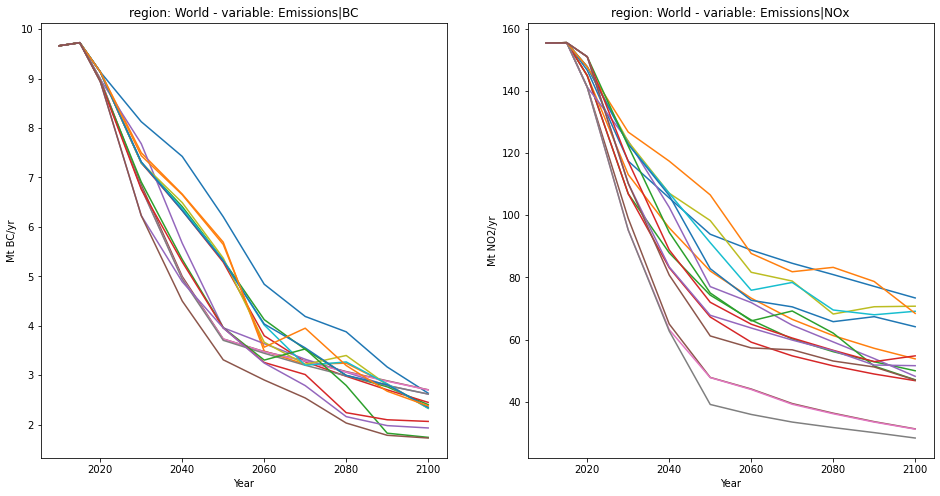

In [70]:
plt.figure(figsize=(16, 8))
ax=plt.subplot(121)
all_extensions.filter(variable="Emissions|BC").plot(ax=ax)
ax=plt.subplot(122)
all_extensions.filter(variable="Emissions|NOx").plot(ax=ax)

In [71]:
# Rename an awkward unit
all_extensions = all_extensions.data
vars_to_convert = [
    "HFC245ca", "C6F14"
]
for var in vars_to_convert:
    ind = [var in y for y in all_extensions["variable"]]
    assert (all_extensions.iloc[ind].value == 0).all()
    index = all_extensions[ind].index
    all_extensions.loc[index, "unit"] = all_extensions.loc[index, "unit"].str.replace(
        "Mt CO2-equiv", "kt " + var)
all_extensions = pyam.IamDataFrame(all_extensions)

# Export .scen files

In [72]:
def construct_scen_file(infilled_data, scen_file_name):
    """Function to construct scen file"""
    def rename_variables(v):
        """Format variables to MAGICC variable convention"""
        mapping = {
        'Emissions|HFC|HFC143a':'Emissions|HFC143a',
        'Emissions|HFC|HFC245fa':"Emissions|HFC245fa",
        'Emissions|CO2|AFOLU':'Emissions|CO2|MAGICC AFOLU',
        'Emissions|HFC|HFC43-10': 'Emissions|HFC4310',
        'Emissions|HFC|HFC32':'Emissions|HFC32',
        'Emissions|HFC|HFC125':'Emissions|HFC125',
        'Emissions|HFC|HFC227ea':'Emissions|HFC227ea',
        'Emissions|CO2|Energy and Industrial Processes': 'Emissions|CO2|MAGICC Fossil and Industrial',
        'Emissions|HFC|HFC134a':'Emissions|HFC134a',
        'Emissions|HFC|HFC23':'Emissions|HFC23',
        'Emissions|PFC|CF4': 'Emissions|CF4',
        'Emissions|PFC|C2F6': 'Emissions|C2F6',
        'Emissions|PFC|C6F14': 'Emissions|C6F14',
        'Emissions|Sulfur': 'Emissions|SOx',
        'Emissions|VOC':'Emissions|NMVOC'
        }
    
        try:
            return mapping[v]
        except KeyError:
            return v

    def replace_units(u):
        """Replace units for NOx"""
            
        mapping = {
            'Mt NOX/yr': 'Mt NO2 / yr',
            'Mt NOx/yr': 'Mt NO2 / yr',
        }
        try:
            return mapping[u]
        except KeyError:
            return u

    # Filter out HFC and non HFC - unit conversions
    non_hfc = infilled_data.filter(variable=["Emissions|HFC*", "Emissions|PFC*"], keep=False)
    hfc = infilled_data.filter(variable=["Emissions|HFC*", "Emissions|PFC*"]).data
    
    # Work around for HFC345ca
    hfc["unit"] = hfc["variable"].apply(
        lambda x: 
        "kt {} / yr".format(
            x
            .split("|")[-1]
            .replace("-", "")
            .replace("245ca", "245fa")
        )
    )
    hfc = pyam.IamDataFrame(hfc)
    enCO2 = non_hfc.filter(variable="Emissions|CO2|Energy and Industrial Processes").data
    enCO2["unit"] = "Mt CO2/yr"
    enCO2 = pyam.IamDataFrame(enCO2)
    non_hfc = non_hfc.filter(
        variable = "Emissions|CO2|Energy and Industrial Processes",
        keep = False
    ).append(enCO2)
    non_hfc = non_hfc.convert_unit("Mt NH3/yr", to="Mt N/yr", factor=14/17)

    # Create an SCM dataframe 
    scen_scm = scmdata.ScmRun(hfc.append(non_hfc))
    writer = pymagicc.io.MAGICCData(scen_scm)
    vars_not_used = [
        "Emissions|CO2", 
        "Emissions|F-Gases",
        'Emissions|kyotoghg_excl_lulucf'    
    ]
    writer = writer.filter(variable=vars_not_used, keep=False)
    # Check whether all the variables are named appropriately
    expected_names = [
        pymagicc.definitions.convert_magicc7_to_openscm_variables(f"{v}_EMIS") 
        for v in pymagicc.definitions.PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1
    ]

    writer["variable"] = writer["variable"].apply(rename_variables)
    writer["unit"] = writer["unit"].apply(replace_units)
    writer["todo"] = "SET"
        
    missing_names = set(expected_names) - set(writer["variable"].unique())
    assert not missing_names, missing_names
    problematic_names = set(writer["variable"].unique()) - set(expected_names)
    assert not problematic_names, problematic_names

    # Unit conversion and cleaning 
    unit_specs = pymagicc.definitions.MAGICC7_EMISSIONS_UNITS.set_index("magicc_variable")
    for v in writer["variable"]:
            magicc_var = pymagicc.definitions.convert_magicc7_to_openscm_variables(
                v, inverse=True).replace("T_EMIS", "").replace("_EMIS", "")
            magicc_unit = unit_specs.loc[magicc_var, "emissions_unit"]
            writer = writer.convert_unit(magicc_unit, variable=v)
    
    # Now we add the 2000 data from the SR1.5 SCEN files to ensure MAGICC doesn't
    # assume constant emissions between 2000 and the start of the SCEN file
    base_scen_file = os.path.join(
        os.path.dirname(os.path.abspath("__file__")),
        "..",
        "Input",
        "IPCCSR15_REMIND-MAgPIE 1.7-3.0_PEP_2C_red_netzero_GAS.SCEN",
    )
    extra_hist = pymagicc.io.MAGICCData(base_scen_file).filter(
        year = range(1, writer["year"].min()),
        region = "World"
    )

    # Overwrite model, scenario names
    extra_hist["scenario"] = writer.get_unique_meta("scenario",True)
    extra_hist["model"] = writer.get_unique_meta("model", True)
    extra_hist["unit"] = extra_hist["unit"].apply(
        lambda x: (
            x
            .replace("134a", "134A")
            .replace("143a", "143A")
            .replace("245fa", "245FA")
            .replace("227ea", "227EA")
        )
    )

    writer = pymagicc.io.MAGICCData(pd.concat(
        [
            extra_hist.timeseries(time_axis="year", meta=writer.timeseries().index.names),
            writer.timeseries(time_axis="year"),
        ],
        axis=1,
    ))
    # Write the scen file
    writer.write("{}.SCEN".format(scen_file_name), magicc_version=6)

In [73]:
scen_folder = f"../output/scens/{version_no}/"
if not os.path.exists(scen_folder):
    os.makedirs(scen_folder)
scen_file = (scen_folder + "{}")

In [74]:
csvfile_folder = f"../output/{version_no}/"
if not os.path.exists(csvfile_folder):
    os.makedirs(csvfile_folder)
all_extensions.to_csv(csvfile_folder + "infilled_emissions.csv")

In [75]:
all_scenarios_renamed = all_extensions.copy().data
all_scenarios_renamed["scenario"] = all_scenarios_renamed["scenario"].str.replace("|", "_")
all_scenarios_renamed = pyam.IamDataFrame(all_scenarios_renamed)

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [76]:
for ind, (model, scenario) in all_scenarios_renamed.data.loc[:, ["model", "scenario"]].drop_duplicates().iterrows():
    construct_scen_file(all_scenarios_renamed.filter(scenario=scenario, model=model).filter(
        variable=['Emissions|Kyoto Gases (AR6-GWP100)', 'Emissions|Kyoto Gases (AR5-GWP100)',
           'Emissions|HFC', 
           'Emissions|Kyoto Gases (AR6-GWP100)|Excluding CO2 AFOLU', 
           'Emissions|PFC', "Price|Carbon"
          ], keep=False), scen_file.format(
        model.replace(".", "-").replace(" ", "_") + "_-_" + scenario.replace(".", "-").replace(" ", "_")
        ))